In [4]:
! pip install -q -U git+https://github.com/google-research/dinosaur --ignore-requires-python

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 68.9 MB/s eta 0:00:00


In [5]:
import functools
import dinosaur
import jax
import numpy as np
import matplotlib.pyplot as plt
import xarray

This notebook uses dinosaur to run the baroclinic test case from [1]. By default we use T42 grid with 24 layers. For more accurate agreement consider using higher resolution (e.g. T85 and 32 model levels).
We recommend using a GPU runtime for this notebook.
[1]:
Jablonowski, C., & Williamson, D. L. (2006). A baroclinic instability test case for atmospheric model dynamical cores. Quarterly Journal of the Royal Meteorological Society: A journal of the atmospheric sciences, applied meteorology and physical oceanography, 132(621C), 2943-2975.

# Atmosphere at rest test

In [6]:
units = dinosaur.scales.units
layers = 24
grid = dinosaur.spherical_harmonic.Grid.T42()
vertical_grid = dinosaur.sigma_coordinates.SigmaCoordinates.equidistant(layers)
coords = dinosaur.coordinate_systems.CoordinateSystem(grid, vertical_grid)
physics_specs = dinosaur.primitive_equations.PrimitiveEquationsSpecs.from_si()

initial_state_fn, aux_features = dinosaur.primitive_equations_states.steady_state_jw(
    coords, physics_specs)
steady_state = initial_state_fn()
ref_temps = aux_features[dinosaur.xarray_utils.REF_TEMP_KEY]
orography = dinosaur.primitive_equations.truncated_modal_orography(
    aux_features[dinosaur.xarray_utils.OROGRAPHY], coords)


def dimensionalize(x: xarray.DataArray, unit: units.Unit) -> xarray.DataArray:
  """Dimensionalizes `xarray.DataArray`s."""
  dimensionalize = functools.partial(physics_specs.dimensionalize, unit=unit)
  return xarray.apply_ufunc(dimensionalize, x)

## Visualization of the initial state

In [7]:
steady_state_dict, _ = dinosaur.pytree_utils.as_dict(steady_state)
u, v = dinosaur.spherical_harmonic.vor_div_to_uv_nodal(
    grid, steady_state.vorticity, steady_state.divergence)
steady_state_dict.update({'u': u, 'v': v, 'z_surf': orography})
nodal_steady_state_fields = dinosaur.coordinate_systems.maybe_to_nodal(
    steady_state_dict, coords=coords)
initial_state_ds = dinosaur.xarray_utils.data_to_xarray(
    nodal_steady_state_fields, coords=coords, times=None)

temperature = dinosaur.xarray_utils.temperature_variation_to_absolute(
    initial_state_ds.temperature_variation.data, ref_temps)
initial_state_ds = initial_state_ds.assign(
    temperature=(initial_state_ds.temperature_variation.dims, temperature))

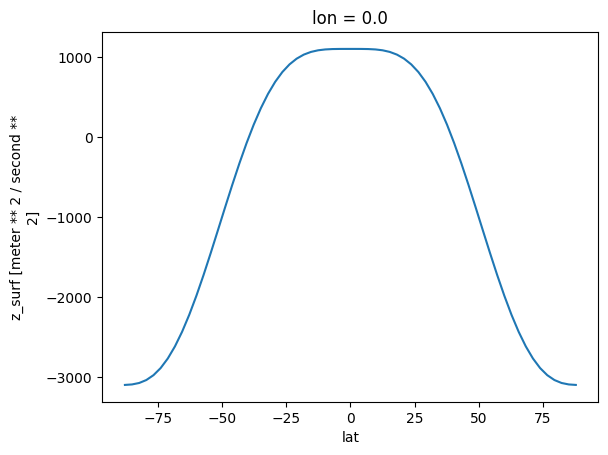

In [8]:
# Surface geopotential vizualization
phi = initial_state_ds['z_surf'] * physics_specs.g
phi_si = dimensionalize(phi, units.m ** 2 / units.s ** 2)
phi_si.isel(lon=0).plot(x='lat');

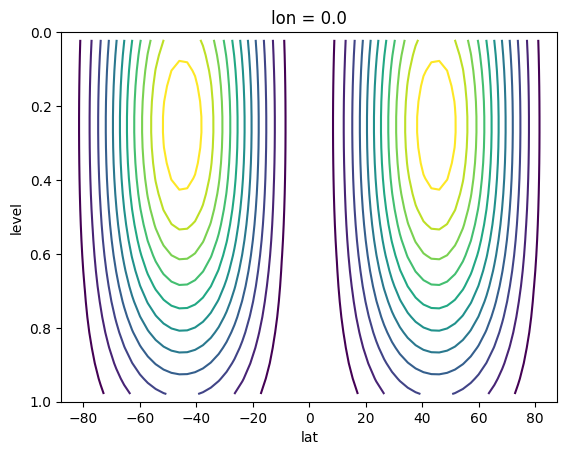

In [9]:
# Zonal wind vizualization
u_array = initial_state_ds['u']
u_array_si = dimensionalize(u_array, units.m / units.s)
levels = [3 * i for i in range(1, 12)]
u_array_si.isel(lon=0).plot.contour(x='lat', y='level', levels=levels)
ax = plt.gca()
ax.set_ylim((1, 0));

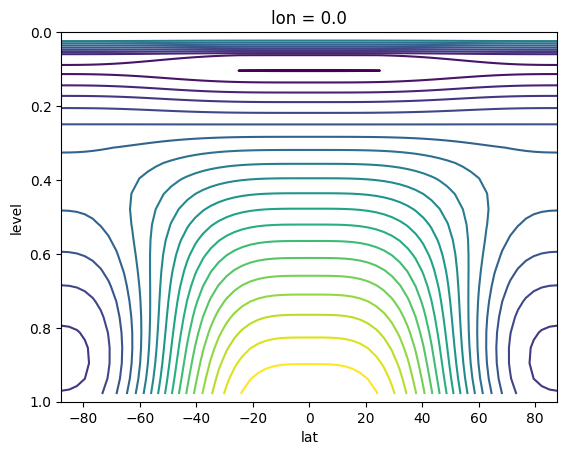

In [10]:
# Temperature vizualization
t_array = initial_state_ds['temperature']
t_array_si = dimensionalize(t_array, units.degK)
levels = np.linspace(210, 305, 1 + (305 - 210) // 5)
t_array_si.isel(lon=0).plot.contour(x='lat', y='level', levels=levels)
ax = plt.gca()
ax.set_ylim((1, 0));

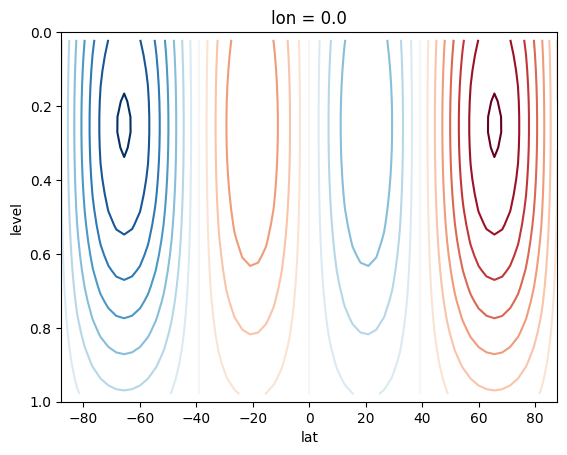

In [11]:
# Relative vorticity vizualization
voriticty_array = initial_state_ds['vorticity']
voriticty_array_si = dimensionalize(voriticty_array, 1 / units.s)
levels = np.linspace(-1.75e-5, 1.75e-5, 15)
voriticty_array_si.isel(lon=0).plot.contour(x='lat', y='level', levels=levels)
ax = plt.gca()
ax.set_ylim((1, 0));

# Initializing the state and running a model forward

In [12]:
# Setting up primitivie equations solver
primitive = dinosaur.primitive_equations.PrimitiveEquations(
    ref_temps, orography, coords, physics_specs)
dt_s = 100 * units.s
dt = physics_specs.nondimensionalize(dt_s)
step_fn = dinosaur.time_integration.imex_rk_sil3(primitive, dt)

## Integration of steady state in time

In [13]:
save_every = 2 * units.hour
total_time = 1 * units.week
inner_steps = int(save_every / dt_s)
outer_steps = int(total_time / save_every)
filters = [dinosaur.time_integration.exponential_step_filter(grid, dt),]
step_fn = dinosaur.time_integration.step_with_filters(step_fn, filters)
integrate_fn = dinosaur.time_integration.trajectory_from_step(
    step_fn, outer_steps, inner_steps)
integrate_fn = jax.jit(integrate_fn)

In [14]:
# Running integration starting with steady state
%time final, trajectory = jax.block_until_ready(integrate_fn(steady_state))

/usr/local/lib/python3.10/dist-packages/dinosaur/sigma_coordinates.py:361: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jnp.zeros(x_slc_shape, dtype=x.dtype),
/usr/local/lib/python3.10/dist-packages/dinosaur/sigma_coordinates.py:362: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jnp.zeros(x_slc_shape, dtype=x.dtype),


CPU times: user 12.1 s, sys: 6.65 s, total: 18.8 s
Wall time: 23 s


In [15]:
# Constructing predictions and diagnostics
trajectory = jax.device_get(trajectory)
times = save_every * np.arange(outer_steps)

trajectory_dict, _ = dinosaur.pytree_utils.as_dict(trajectory)
u, v = dinosaur.spherical_harmonic.vor_div_to_uv_nodal(
    grid, trajectory.vorticity, trajectory.divergence)
trajectory_dict.update({'u': u, 'v': v})
nodal_trajectory_fields = dinosaur.coordinate_systems.maybe_to_nodal(
    trajectory_dict, coords=coords)
trajectory_ds = dinosaur.xarray_utils.data_to_xarray(
    nodal_trajectory_fields, coords=coords, times=times)

trajectory_ds['surface_pressure'] = np.exp(trajectory_ds.log_surface_pressure[:, 0, :,:])
temperature = dinosaur.xarray_utils.temperature_variation_to_absolute(
    trajectory_ds.temperature_variation.data, ref_temps)
trajectory_ds = trajectory_ds.assign(
    temperature=(trajectory_ds.temperature_variation.dims, temperature))

/usr/local/lib/python3.10/dist-packages/xarray/core/indexes.py:190: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  index = pd.Index(np.asarray(array), **kwargs)


 First we verify that the steady state is indeed stationary (i.e. no apparent changes over the course of 7-day integration)

### Vorticity dynamics

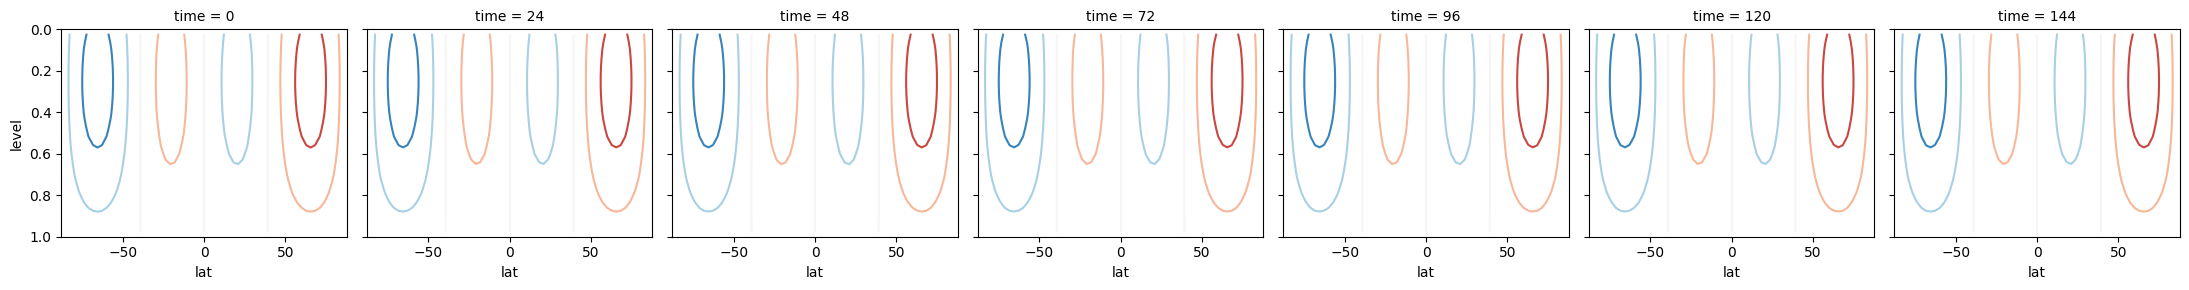

In [16]:
data_array = trajectory_ds['vorticity']

data_array.isel(lon=0).thin(time=12).plot.contour(x='lat', y='level', col='time')
ax = plt.gca()
ax.set_ylim((1, 0));

### Pressure dynamics

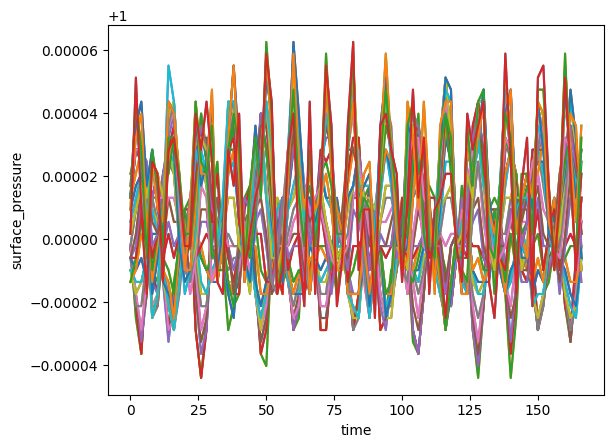

In [17]:
# normalized surface pressure should remain roughly constant
data_array = (trajectory_ds['surface_pressure'] /
              physics_specs.nondimensionalize(1e5 * units.pascal))
data_array.max(['lon']).plot(x='time', hue='lat')
ax = plt.gca()
ax.legend().remove()

### Temperature dynamics

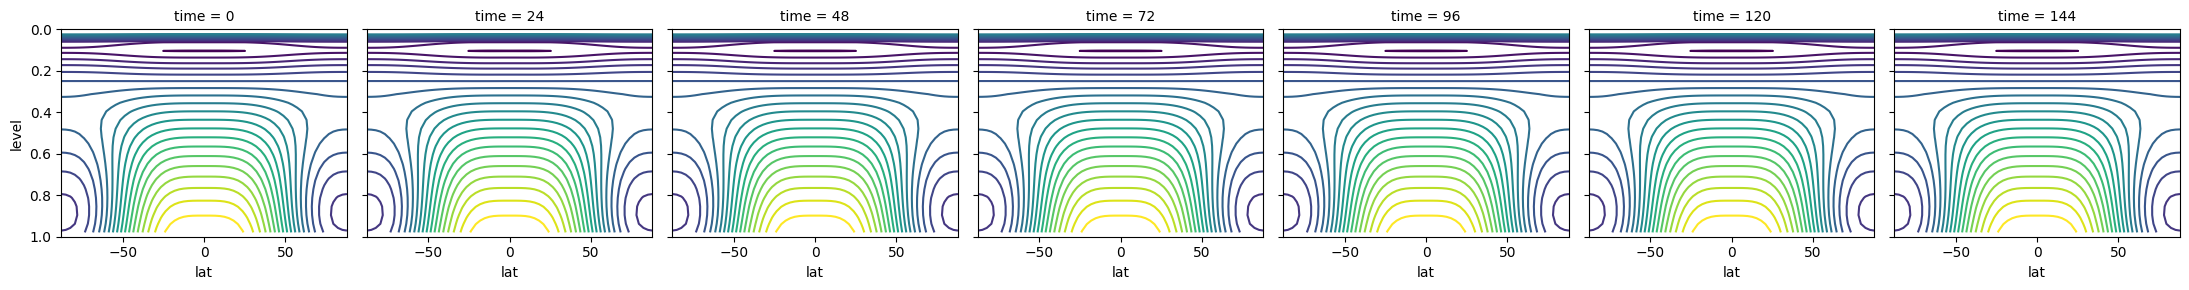

In [18]:
t_array = trajectory_ds['temperature']
t_array_si = dimensionalize(t_array, units.degK)
levels = np.linspace(210, 305, 1 + (305 - 210) // 5)
t_array_si.isel(lon=0).thin(time=12).plot.contour(
    x='lat', y='level', levels=levels, col='time')
ax = plt.gca()
ax.set_ylim((1, 0));

### Divergence

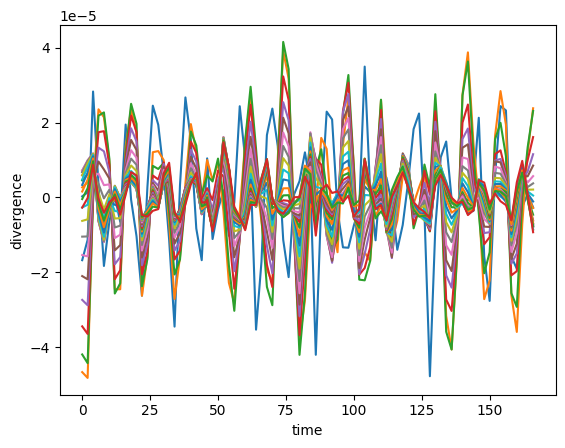

In [19]:
# Divergence is expected to be very close to 0 throughout
data_array = trajectory_ds['divergence']
data_array.mean(['lat', 'lon']).plot(x='time', hue='level')
ax = plt.gca()
ax.legend().remove();

# Initiating instability

In this stage we add a prescribed perturbation to the steady state and observe the evolution of baroclinic instability

In [20]:
perturbation = dinosaur.primitive_equations_states.baroclinic_perturbation_jw(
    coords, physics_specs)
state = steady_state + perturbation

In [21]:
save_every = 2 * units.hour
total_time = 2 * units.week
inner_steps = int(save_every / dt_s)
outer_steps = int(total_time / save_every)
integrate_fn = dinosaur.time_integration.trajectory_from_step(
    step_fn, outer_steps, inner_steps)
integrate_fn = jax.jit(integrate_fn)

In [22]:
%time final, trajectory = jax.block_until_ready(integrate_fn(state))

/usr/local/lib/python3.10/dist-packages/dinosaur/sigma_coordinates.py:361: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jnp.zeros(x_slc_shape, dtype=x.dtype),
/usr/local/lib/python3.10/dist-packages/dinosaur/sigma_coordinates.py:362: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jnp.zeros(x_slc_shape, dtype=x.dtype),


CPU times: user 19.1 s, sys: 15.1 s, total: 34.2 s
Wall time: 38.1 s


In [23]:
# formatting predictions to xarray.Dataset for ease of vizualization
trajectory = jax.device_get(trajectory)
times = (save_every * np.arange(outer_steps)).to(units.s)

trajectory_dict, _ = dinosaur.pytree_utils.as_dict(trajectory)
u, v = dinosaur.spherical_harmonic.vor_div_to_uv_nodal(
    grid, trajectory.vorticity, trajectory.divergence)
trajectory_dict.update({'u': u, 'v': v})
nodal_trajectory_fields = dinosaur.coordinate_systems.maybe_to_nodal(
    trajectory_dict, coords=coords)
trajectory_ds = dinosaur.xarray_utils.data_to_xarray(
    nodal_trajectory_fields, coords=coords, times=times)

trajectory_ds['surface_pressure'] = np.exp(trajectory_ds.log_surface_pressure[:, 0, :,:])
temperature = dinosaur.xarray_utils.temperature_variation_to_absolute(
    trajectory_ds.temperature_variation.data, ref_temps)
trajectory_ds = trajectory_ds.assign(
    temperature=(trajectory_ds.temperature_variation.dims, temperature))

/usr/local/lib/python3.10/dist-packages/xarray/core/indexes.py:190: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  index = pd.Index(np.asarray(array), **kwargs)


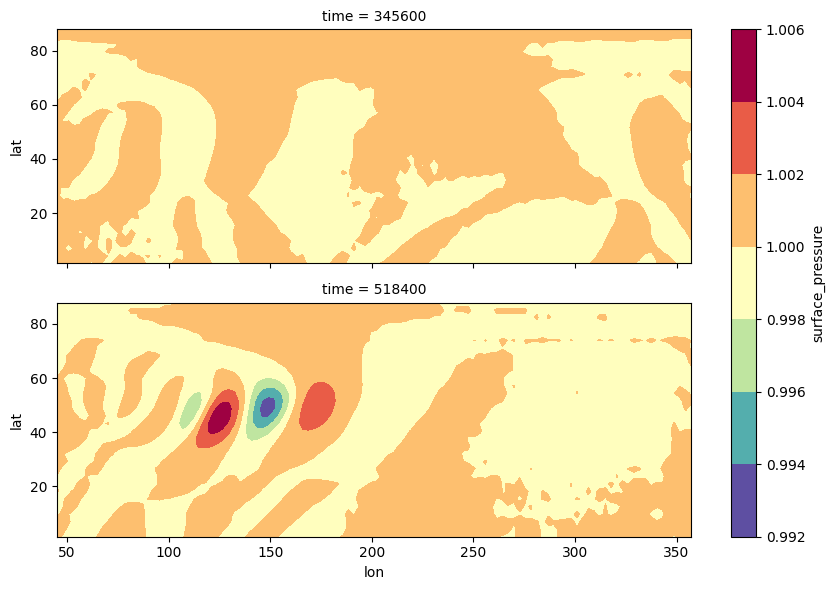

In [24]:
# Contour plots of log-surface pressure at 4/6 days
data_array = (trajectory_ds['surface_pressure'] /
              physics_specs.nondimensionalize(1e5 * units.pascal))
levels = [(992 + 2 * i) / 1000 for i in range(8)]

data_array.sel(
    {'lat': slice(0, 90),
     'lon': slice(45, 360),
     'time': [(4 * units.day).to(units.s).m,
               (6 * units.day).to(units.s).m],}
     ).plot.contourf(
         x='lon', y='lat', row='time', levels=levels, cmap=plt.cm.Spectral_r)

fig = plt.gcf()
fig.set_figwidth(10)

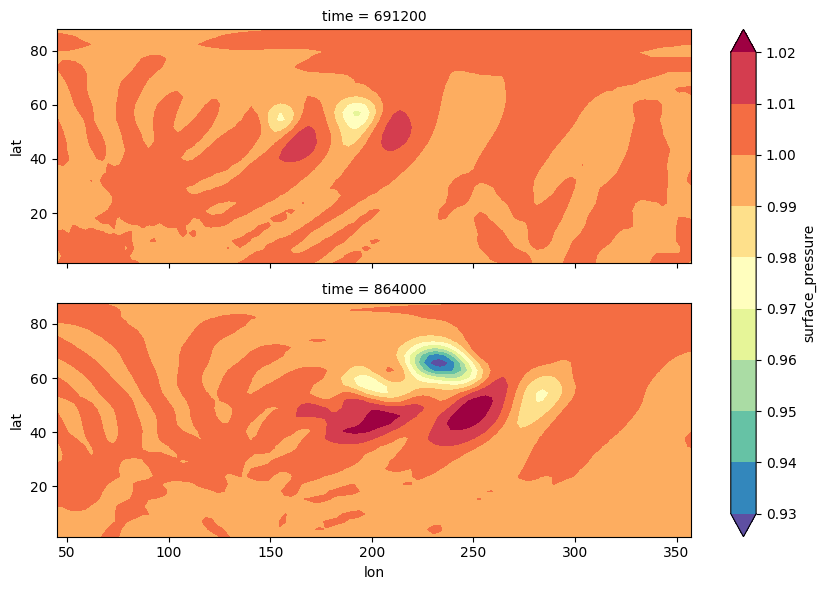

In [25]:
# Contour plots of log-surface pressure at 8 and 10 days
data_array = (trajectory_ds['surface_pressure'] /
              physics_specs.nondimensionalize(1e5 * units.pascal))
levels = [(930 + 10 * i) / 1000 for i in range(10)]

(data_array.sel({'lat': slice(0, 90),
                 'lon': slice(45, 360),
                 'time': [(8 * units.day).to(units.s).m,
                           (10 * units.day).to(units.s).m]})
           .plot.contourf(x='lon',
                          y='lat',
                          row='time',
                          levels=levels,
                          cmap=plt.cm.Spectral_r))

fig = plt.gcf()
fig.set_figwidth(10)

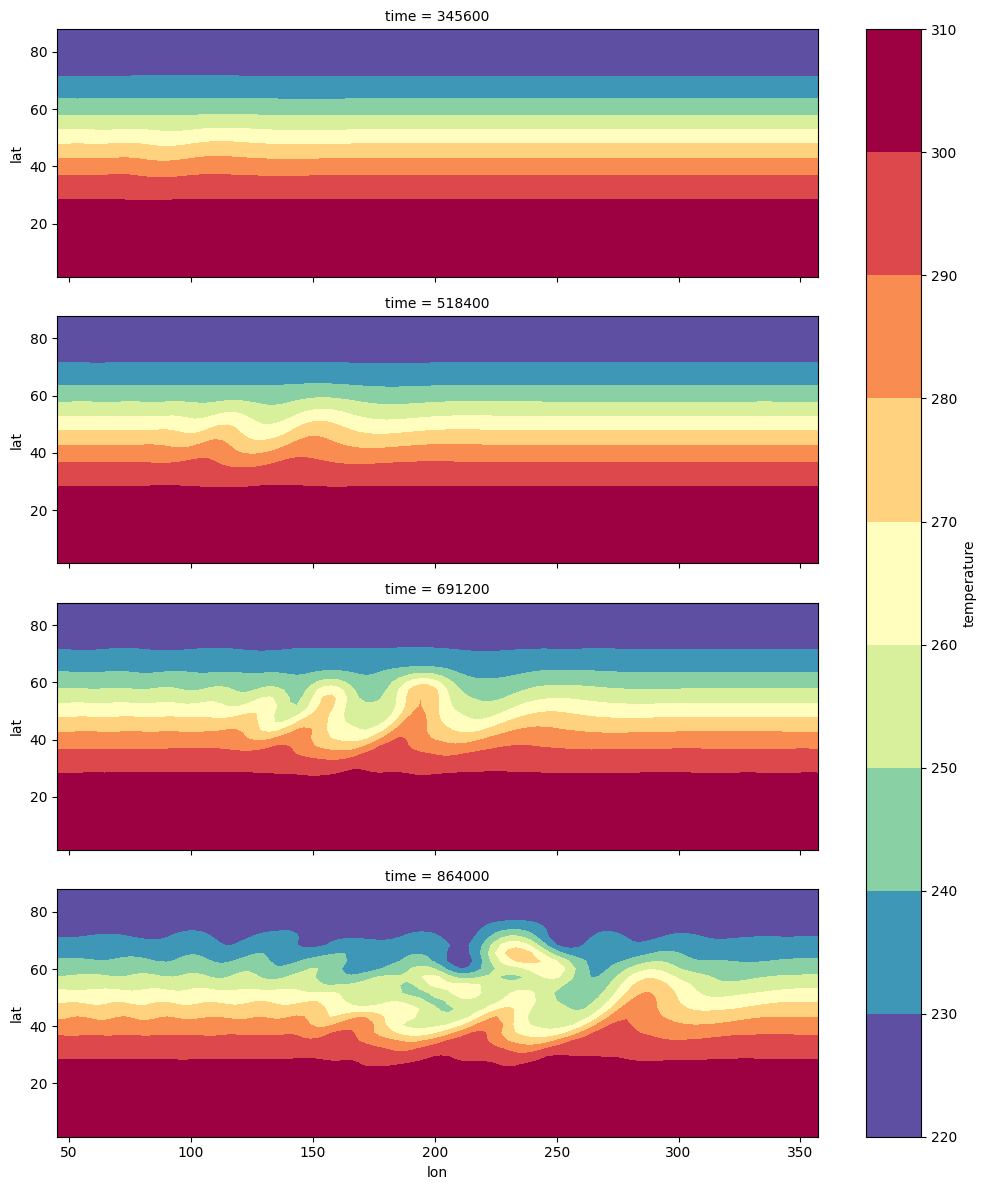

In [26]:
# Temperature at days 4, 6, 8, 10 (note we do not interpolate to exactly 850hPa)
temp_array = trajectory_ds['temperature']
levels = [(220 + 10 * i) for i in range(10)]
target_pressure = 0.85 * physics_specs.nondimensionalize(1e5 * units.pascal)  # TODO: add interpolation

(temp_array.sel({'lat': slice(0, 90),
                 'lon': slice(45, 360),
                 'time': [(4 * units.day).to(units.s).m,
                           (6 * units.day).to(units.s).m,
                           (8 * units.day).to(units.s).m,
                           (10 * units.day).to(units.s).m]})
           .isel(level=22)
           .plot.contourf(x='lon',
                          y='lat',
                          row='time',
                          levels=levels,
                          cmap=plt.cm.Spectral_r))
fig = plt.gcf()
fig.set_figwidth(12)

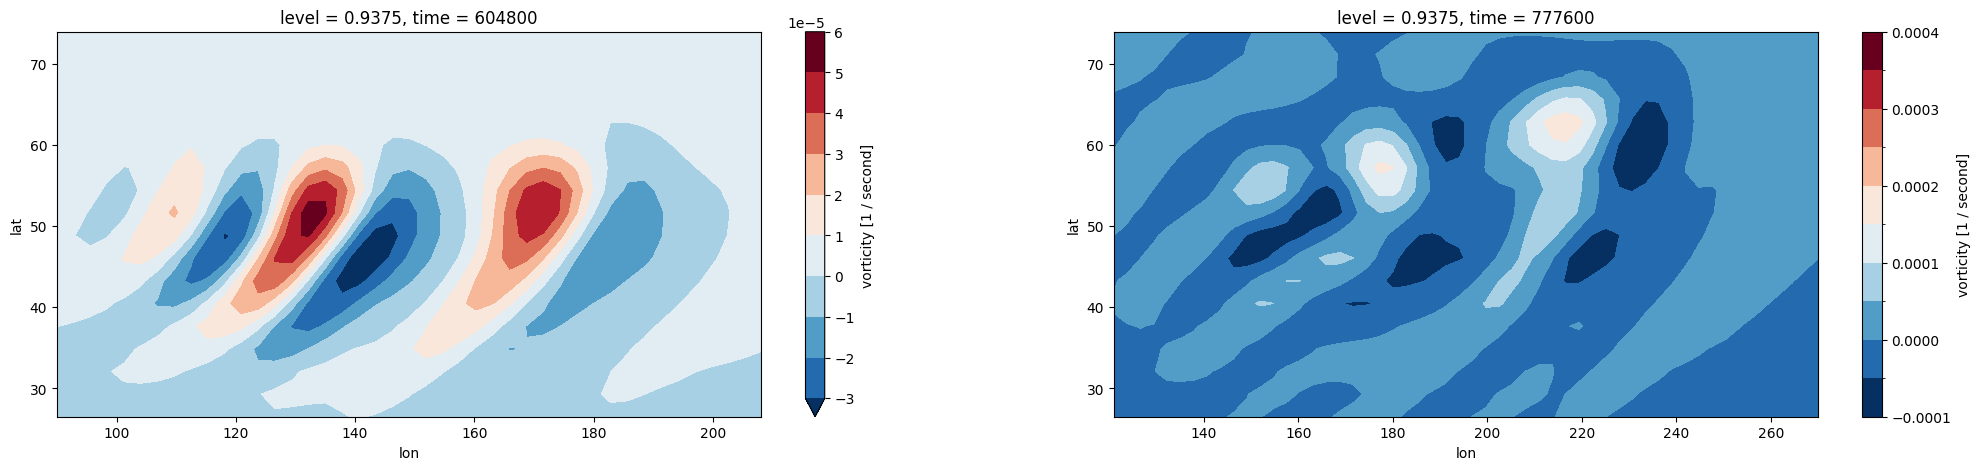

In [27]:
# Vorticity features
voriticty_array = trajectory_ds['vorticity']
target_pressure = 0.85 * physics_specs.nondimensionalize(1e5 * units.pascal)  # TODO: add interpolation
voriticty_array_si = dimensionalize(voriticty_array, 1/ units.s)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

levels = [-3e-5 + 1e-5 * i for i in range(10)]
(voriticty_array_si.sel({'lat': slice(25, 75),
                         'lon': slice(90, 210),
                         'time': (7 * units.day).to(units.s).m})
                   .isel(level=22)
                   .plot.contourf(x='lon',
                                  y='lat',
                                  levels=levels,
                                  ax=ax1))

levels = [-10e-5 + 5e-5 * i for i in range(11)]
(voriticty_array_si.sel({'lat': slice(25, 75),
                         'lon': slice(120, 270),
                         'time': (9 * units.day).to(units.s).m})
                   .isel(level=22)
                   .plot.contourf(x='lon',
                                  y='lat',
                                  levels=levels,
                                  ax=ax2))
fig.set_figwidth(25)

/usr/local/lib/python3.10/dist-packages/numpy/core/numerictypes.py:511: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  cast[key] = lambda x, k=key: array(x, copy=False).astype(k)


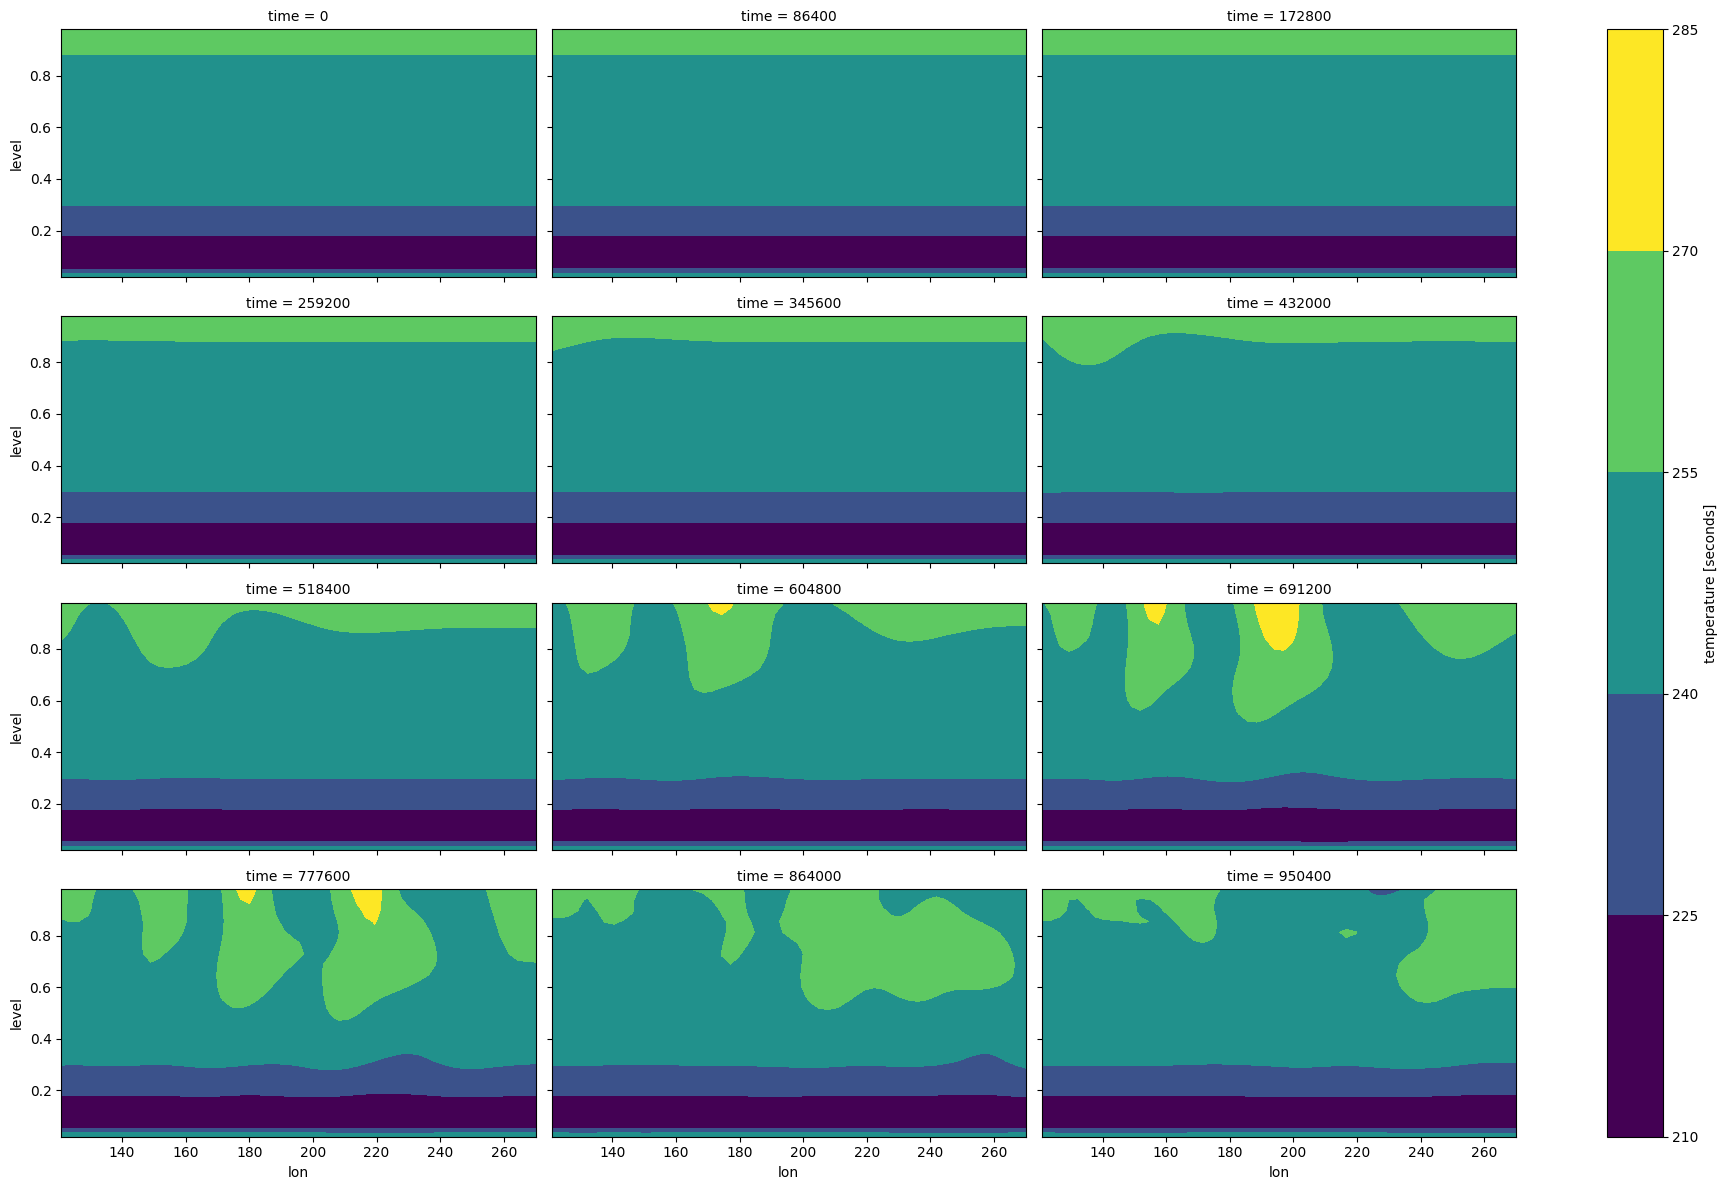

In [28]:
# Daily vertical slices of temperature.
times = np.cast[np.int32]((np.arange(12) * units.day).to(units.second))
data = (temp_array.sel(lat=slice(54, 56),
                lon=slice(120, 270),
                time=times)
            .isel(lat=0))
data.attrs['units'] = 'seconds'
data.plot.contourf(x='lon', y='level', row='time',
                           aspect=2, col_wrap=3);
